In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from collections import OrderedDict


In [2]:
def generate_data(init, end, num_points, plot=1):
    #declare a list of coefficients 
    coeff=[5,1,1]
    noise=2
    # generate x_coordinate of line
    x = np.arange(0,50,(50-0)/100)
    line = coeff[0]
    #generate y_coordinates of line
    for idx in np.arange(1, len(coeff)):
        line += coeff[idx]*x**idx
        if noise>0:
            y= np.random.normal(-(10**noise), 10**noise, len(x))+line
        else: y= line
    if plot==1:
        plt.figure(figsize=(10,6))
        plt.scatter(x_pts, y_pts, color='r')
        plt.xlabel('x')
        plt.ylabel('y')
    
    return x, y

In [3]:
def generatePoints(start, stop, num_points, coeff, noiseLevel = 1, plot = 1):
    """
    Generate evenly spaced x and y coordinates in Euclidean space from a polynomial
    with gaussian noise      
    x_pts : 1-d array, shape = [num_points,]     
    y_pts : 1-d array, shape = [num_points,]

    """
    x_pts = np.arange(start, stop, (stop - start)/num_points)
    line = coeff[0]
    
    for i in np.arange(1, len(coeff)):          
        line += coeff[i] * x_pts ** i 

    if noiseLevel > 0:
        y_pts = np.random.normal(-(10 ** noiseLevel), 10 ** noiseLevel, len(x_pts)) + line
    else:
        y_pts = line

    if plot == 1: #Plot option
        plt.figure(figsize=(10,6))
        plt.scatter(x_pts, y_pts, color='r')
        plt.xlabel('x')
        plt.ylabel('y')
        
    return x_pts, y_pts

In [4]:
x_pts, y_pts = generatePoints(0, 50, 100, [5, 1, 1], 
                                  noiseLevel =2, plot = 1)

In [7]:
class PolynomialRegression(object):
    """PolynomialRegression 
        
        Parameters
        ------------
        x_pts : 1-d numpy array, shape = [n_samples,]
        y_pts : 1-d numpy array, shape = [n_samples,]
    

        Attributes
        ------------
        theta : 1-d numpy array, shape = [polynomial order + 1,] 
            Ceofficients of fitted polynomial, with theta[0] corresponding
            to the intercept term        
        
        method : str , values = 'normal_equation' | 'Newtons method'
            Method used for finding optimal values of theta
        ------------
        
    """
    def __init__(self, x, y):     
        
        self.x = x
        self.y = y  
        
    def hypothesis(self, theta, x):
        """ 
         
        h(x) = theta_0*(x_1**0) + theta_1*(x_1**1) + ...+ theta_n*(x_1 ** n)
        
        Parameters:
        ------------
        theta : numpy-array, shape = [polynomial order + 1,]        
        x : numpy-array, shape = [n_samples,]
        
        Returns:
        ---------
        h(x) given theta values and the training data

        """       
        h = theta[0]
        for i in np.arange(1, len(theta)):
            h += theta[i]*x ** i        
        return h   
    
    def swapRows(self, v,i,j):
        """
        Swaping:
        ----------
        swapRows(v,i,j).
        Swaps rows i and j of a vector or matrix [v].
        
        """
        if len(v.shape) == 1:
            v[i],v[j] = v[j],v[i]
        else:
            v[[i,j],:] = v[[j,i],:]
        
    def swapCols(self, v,i,j):
        """
        Swaping:
        ----------
        swapCols(v,i,j).
        Swaps columns of matrix [v].
        
        """
        v[:,[i,j]] = v[:,[j,i]]
    
    def LUdecomp(self, a,tol=1.0e-9):
        """
        LU Decomposition:
        ------------
        a = LUdecomp(a)
        LUdecomposition: [L][U] = [a]
        
        """
        n = len(a)
        seq = np.array(range(n))
    
        # Set up scale factors
        s = np.zeros((n))
        for i in range(n):
            s[i] = max(abs(a[i,:]))
        
        for k in range(0,n-1):
            # Row interchange, if needed
            p = np.argmax(np.abs(a[k:n,k])/s[k:n]) + k
            if abs(a[p,k]) < tol: print('Matrix is singular')
            if p != k:
                self.swapRows(s,k,p)
                self.swapRows(a,k,p)
                self.swapRows(seq,k,p)
            # Elimination
            for i in range(k+1,n):
                if a[i,k] != 0.0:
                    lam = a[i,k]/a[k,k]
                    a[i,k+1:n] = a[i,k+1:n] - lam*a[k,k+1:n]
                    a[i,k] = lam
        return a, seq
    
    def LUsolve(self,a,b,seq):
        """
        Solve Linear equations
        -------------
        x = LUsolve(a,b)
        Solution phase: solves [L][U]{x} = {b}
        
        """
        n = len(a)
        # Rearrange constant vector; store it in [x]
        x = b.copy()
        for i in range(n):
            #print(seq[i])
            x[i] = b[seq[i]]
        # Solution
        for k in range(1,n):
            x[k] = x[k] - np.dot(a[k,0:k],x[0:k])
        x[n-1] = x[n-1]/a[n-1,n-1]
        for k in range(n-2,-1,-1):
            x[k] = (x[k] - np.dot(a[k,k+1:n],x[k+1:n]))/a[k,k]
        return x
    
    def matInv(self,a):
        """
        Calacute inverse of matrix a:
        ----------------------------
        input matrix:a
         retrun: aInv
        
        """
        n = len(a[0])
        aInv = np.identity(n)
        a,seq = self.LUdecomp(a)
        for i in range(n):
            aInv[:,i] = self.LUsolve(a,aInv[:,i],seq)
        return aInv

    def fit(self, lamda, order, method = 'normal_equation' ):
        
        """Fit theta to the training data to the model of the form:
        
            h(x) = theta_0*(x_1**0) + theta_1*(x_1**1) + ...+ theta_n*(x_1 ** n)
            
        """
        #print("fit")
        if method == 'normal_equation': 
            d = {}
            d['x' + str(0)] = np.ones([1,len(self.x)])[0]    
            for i in np.arange(1, order+1):                
                d['x' + str(i)] = self.x ** (i)        
                
            d = OrderedDict(sorted(d.items(), key=lambda t: t[0]))
            X = np.column_stack(d.values())  
            #print("X Shape", X.shape)
            I = np.eye(order+1)*lamda*order
            
            a = np.matmul(np.transpose(X),X)
            #print("Mul matrix a:",a)
            #b = a+I
            #print("a+I", b)
            #print(linalg.pinv(np.matmul(np.transpose(X),X)))
            #print(linalg.pinv(np.matmul(np.transpose(X),X)+I))

            theta = np.matmul(np.matmul(self.matInv(np.matmul(np.transpose(X),X)+I), np.transpose(X)), self.y)

            
        self.method = method    
        self.theta = theta        

        return self
    
    def calculate_error(self):
        
        '''
        Parameters: 
        ---------
        theta : numpy-array, shape = [polynomial order + 1,]        
        x : numpy-array, shape = [n_samples,]
        y : 1-d numpy array, shape = [n_samples,]
        
        Returns:
        ---------
       Sum of squared error between predicted-y and true-y
        
        '''
        
        m = len(self.y)  
        h = self.hypothesis(self.theta, self.x)
        errors = h-self.y
        fit_line=''
        fit_line=fit_line+str(self.theta[0])
        for i in np.arange(1, len(self.theta)): 
            
            fit_line = fit_line+' + ' + str(self.theta[i]) + r'x^' + str(i)  
        
        print("LSE:")
        print("Fitting Line::::",fit_line)
        
        return (1/(2*m))*np.sum(errors**2) 
    
    
    def plot_predictedPolyLine(self):
        """Plot predicted polynomial line using values of theta found
        using normal equation or newtons method
        
        Returns
        -----------       
        matploblib figure
        """     
        print("plot predict")
        plt.figure(figsize=(10,6))
        plt.scatter(self.x, self.y, s = 30, c = 'r') 
        line = self.theta[0] #y-intercept 
        label_holder = []
        label_holder.append('%.*f' % (2, self.theta[0]))
        for i in np.arange(1, len(self.theta)):            
            line += self.theta[i] * self.x ** i 
            label_holder.append(' + ' +'%.*f' % (2, self.theta[i]) + r'$x^' + str(i) + '$') 
        
        plt.plot(self.x, line, label = ''.join(label_holder), color='g')        
        plt.title('Polynomial Fit: Order ' + str(len(self.theta)-1))
        plt.xlabel('x')
        plt.ylabel('y') 
        plt.legend(loc = 'best')      


In [8]:
print("*******Demo of Polynomial Regression********")
print("  ")
#print("1.Generate Input Data Matrix X with m (data examples) rows and n (features) columns")
#M = input("Enter the number of rows M of input matrix X: \n")
#N = input("Enter the number of columns N of input matrix X: \n")
order = input("Input the number of polynomial bases:  ")
order = int(order)
lamda = input("Input the lambda value for regularization:  ")
lamda = float(lamda)
print("------------------------")
print("  ")
PR = PolynomialRegression(x_pts, y_pts)
PR.fit(lamda, order, method = 'normal_equation')
error = PR.calculate_error()
print(" ")
print("Prediction error:", error)
print("------------------------")

*******Demo of Polynomial Regression********
  
Input the number of polynomial bases:  6
Input the lambda value for regularization:  500
------------------------
  
LSE:
Fitting Line:::: -0.346352865183124 + -0.6920809339651522x^1 + -0.9787136642510927x^2 + 0.18807288588598237x^3 + -0.007291886778573002x^4 + 0.00013158650296114132x^5 + -9.07244462535308e-07x^6
 
Prediction error: 6435.848087444264
------------------------


plot predict


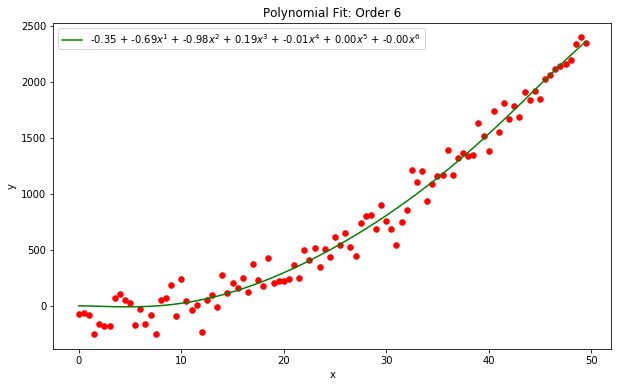

In [9]:
PR.plot_predictedPolyLine()